In [1]:
# 采用Transfer Learning,对VGG16进行特征抽取
# 即对VGG16中Flatten后面的神经层全部去掉，换上我们自己的神经层，这个行为叫做特征抽取
# 注：VGG16中，前面的多重卷积层和池化层对图像特征已做了很好的提取，此部分可以直接使用

# 通过代码来初始化一个VGG16网络实例
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 下载vgg16模型预训练权重，将之放到~/.keras/model/下面，
# 这样在keras导入vgg16的时候就不会联网下载

# weight参数告诉程序将网络的卷积层和max pooling层对应的参数传递过来，
# 并将它们初始化成对应的网络层次
# include_top表示是否也要把Flatten()后面的网络层也下载过来
# input_shape告诉网络，我们输入图片的大小是150*150像素，每个像素由[R, G, B]三个值表示
conv_base = VGG16(weights="imagenet", include_top=False,input_shape = (150,150,3))

conv_base.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [2]:
# 接下来我们将把自己的图片读进来，
# 把图片喂给上面网络，让它把图片的隐含信息给抽取出来
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "C:/Users/hh/Desktop/Kaggle/2.0 CatdogNet/input/train3"
train_dir = os.path.join(base_dir,"train")
validation_dir = os.path.join(base_dir,"validation")
test_dir = os.path.join(base_dir,"test")

datagen = ImageDataGenerator(rescale = 1. / 255)
batch_size = 20

# generator 实际上是将数据批量读入内存，使得代码能以for in 的方式去方便的访问
# 利用VGG16的卷积层把图片的特征抽取出来
def extract_features(directory,sample_count):
    features = np.zeros(shape = (sample_count,4,4,512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(directory,target_size = (150,150),
                                           batch_size = batch_size,
                                           class_mode = "binary")
    i = 0
    for inputs_batch,labels_batch in generator:
        # 把图片输入VGG16层的卷积层，让它把图片信息抽取出来
        features_batch = conv_base.predict(inputs_batch)
        # feature_batch是4*4*512结构的
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # for in 在generator上的循环是无限的，因此需要主动break掉
            break
        return features,labels
# extract_features返回数据格式为（samples，4,4,512）
train_features,train_labels = extract_features(train_dir,2000)
validation_features,validation_labels = extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# 上面代码利用VGG16的卷积层把图片的特征抽取出来，
# 接下来就可以把抽取的特征输入到我们自己的神经层中进行分类
train_features = np.reshape(train_features,(2000,4*4*512))
validation_features = np.reshape(validation_features,(1000,4*4*512))
test_features = np.reshape(test_features,(1000,4*4*512))

from keras import models
from keras import layers
from keras import optimizers

# 构造新的网络对输出层进行分类
model = models.Sequential()
model.add(layers.Dense(256,activation = "relu",input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation = "sigmoid"))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5), loss = "binary_crossentropy",
             metrics = ["acc"])
history = model.fit(train_features,train_labels,epochs = 30,batch_size = 20,
                   validation_data = (validation_features,validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6905 - acc: 0.9945 - val_loss: 0.6842 - val_acc: 0.9930
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6837 - acc: 0.9965 - val_loss: 0.6761 - val_acc: 0.9930
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6734 - acc: 0.9970 - val_loss: 0.6679 - val_acc: 0.9930
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6634 - acc: 0.9975 - val_loss: 0.6599 - val_acc: 0.9930
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6549 - acc: 0.9975 - val_loss: 0.6501 - val_acc: 0.9930
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6438 - acc: 0.9985 - val_loss: 0.6409 - val_acc: 0.9930
Epoch 7/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6340 - acc: 0.9990 - val_loss: 0.6325 - val_acc: 0.9930
Epoch 8/30
200

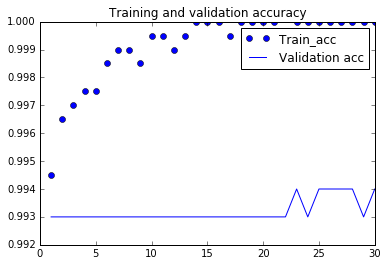

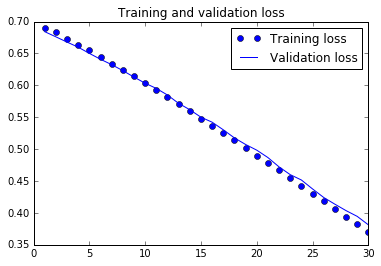

In [5]:
# 绘制曲线
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,"bo",label = "Train_acc")
plt.plot(epochs,val_acc,"b",label = "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs,loss,"bo",label = "Training loss")
plt.plot(epochs,val_loss,"b",label= "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [26]:
"""

上图就是我们从VGG16拿到的卷积层，我们用自己的图片去训练修改它最高的两层，
其他层次不做修改，这种只影响模型一部分的方法就叫参数调优。
调优必须只对VGG16的卷积层做小范围修改，因为它的模型是经过大数据，
反复训练得到的，如果我们对它进行大范围修改，就会破坏它原来训练的结果，
这样人家辛苦做出来的工作成果就会被我们毁于一旦。所以参数调优的步骤如下：

1，将我们自己的网络层添加到VGG16的卷积层之上。 
2，固定VGG16的卷积层保持不变。 
3，用数据训练我们自己添加的网络层 
4，将VGG16的卷积层最高两层放开 
5，用数据同时训练放开的那两层卷积层和我们自己添加的网络层

"""

model = models.Sequential()
# 将VGG16的卷积层直接添加到我们自己的网络
model.add(conv_base)
# 添加我们自己的网络层
model.add(layers.Flatten())
model.add(layers.Dense(256,activation = "relu"))
model.add(layers.Dense(1,activation = "sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [29]:
"""
从上面输出结果看，VGG16的卷积层已经有一千多万个参数了！
用个人电脑单个CPU是不可能对这个模型进行训练的！
但我们可以训练它的其中一部分，我们把它最高三层与我们自己的网络层结合在一起训练，
同时冻结最低四层。下面的代码将会把卷积层进行部分冻结：
"""
conv_base.trainable = True
set_trainable = False
# 一旦读取到“block_conv1”时，意味着来到了卷积网络的最高三层
# 可以使用con_based.summary() 来查看卷积层的信息
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        # 当Trainable == True 意味着该网络层可以更改，要不然该网络层会被冻结，不能修改
        layer.trainable = True
    else:
        layer.trainable = False


In [30]:
# 然后我们把数据传入网络，训练给定的卷积层和我们自己的网络层

# 把图片数据读取进来
test_datagen = ImageDataGenerator(rescale = 1. / 255)
train_generator = test_datagen.flow_from_directory(train_dir,target_size = (150,150),
                                                  batch_size = 20, class_mode = "binary")
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size = (150,150),
                                                       batch_size = 20,
                                                       class_mode = "binary")
model.compile(loss = "binary_crossentropy",optimizer = optimizers.RMSprop(2e-5),
             metrics = ["acc"])
history = model.fit_generator(train_generator,steps_per_epoch = 100, epochs = 30,
                             validation_data = validation_generator,
                             validation_steps = 50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 476s 5s/step - loss: 0.3521 - acc: 0.8490 - val_loss: 0.2231 - val_acc: 0.9100
Epoch 2/30
100/100 [==============================] - 478s 5s/step - loss: 0.1645 - acc: 0.9400 - val_loss: 0.1940 - val_acc: 0.9100
Epoch 3/30
100/100 [==============================] - 475s 5s/step - loss: 0.0873 - acc: 0.9730 - val_loss: 0.1859 - val_acc: 0.9220
Epoch 4/30
100/100 [==============================] - 480s 5s/step - loss: 0.0505 - acc: 0.9825 - val_loss: 0.3072 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 480s 5s/step - loss: 0.0234 - acc: 0.9940 - val_loss: 0.2402 - val_acc: 0.9210
Epoch 6/30
100/100 [==============================] - 479s 5s/step - loss: 0.0137 - acc: 0.9950 - val_loss: 0.2124 - val_acc: 0.9130
Epoch 7/30
100/100 [==============================] - 482s 5s/step - loss: 0.0075 - acc: 0.9980 - val_loss: 0.2455 - v

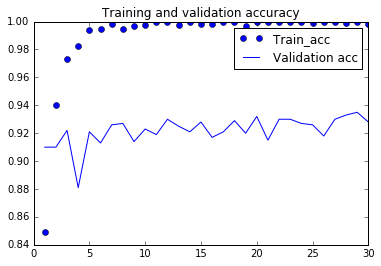

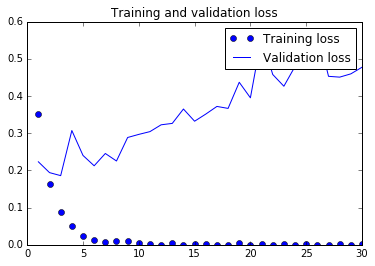

In [31]:
# 绘制曲线
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,"bo",label = "Train_acc")
plt.plot(epochs,val_acc,"b",label = "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs,loss,"bo",label = "Training loss")
plt.plot(epochs,val_loss,"b",label= "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [ ]:
#  link    https://blog.csdn.net/tyler_download/article/details/81179229